Comprobar wavelet.

In [7]:
import sounddevice as sd
import pywt
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab
import wave
import os

In [8]:
N = 512
levels = 4
#wavelet_name = "haar"
#wavelet_name = "db5"
#wavelet_name = "db20"
#wavelet_name = "bior2.2"
#wavelet_name = "rbio2.2"
#wavelet_name = "coif2"
wavelet_name = "db3"
#wavelet_name = "sym2"
#wavelet_name = "sym4"
#wavelet_name = "bior4.4"
#wavelet_name = "bior4.5"
#wavelet_name = "rbio1.3"
wavelet = pywt.Wavelet(wavelet_name)
signal_mode_extension = "per"
quantization_step = 256
chunk_size = 2048

RD Curves

In [9]:
fs = 44100      # Sampling frequency
duration = 5.0  # seconds
x = sd.rec(int(duration * fs), samplerate=fs, channels=2, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")

Say something!
done


In [23]:
def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)

def RMSE(x, y):
    error_signal = x - y
    return math.sqrt(average_energy(error_signal))

def entropy_in_bits_per_symbol(sequence_of_symbols):
    value, counts = np.unique(sequence_of_symbols, return_counts = True)
    probs = counts / len(sequence_of_symbols)
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    entropy = 0.
    for i in probs:
        entropy -= i * math.log(i, 2)

    return entropy

def write_audio(x):
    fp = wave.Wave_write('/tmp/audio.wav')
    fp.setframerate(fs)
    fp.setnframes(37*44100)
    fp.setnchannels(2)
    fp.setsampwidth(2)

    #Write directory
    fp.writeframes(x.tobytes())
    fp.close()

def bit_rate(x):
    write_audio(x)
    length_in_bytes = os.path.getsize("/tmp/audio.wav")
    return length_in_bytes * 8

def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int32)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

def q_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        k, y = q_deq(data, q_step)
        rate = bit_rate(k[:, 0]) + bit_rate(k[:, 1])
        distortion = RMSE(data, y)
        RD_points.append((rate, distortion))
    print("Distortion", distortion)
    return RD_points

def MST_analyze(x):
    w = np.empty_like(x, dtype=np.int32)
    w[:, 0] = x[:, 0].astype(np.int32) + x[:, 1] # L(ow frequency subband)
    w[:, 1] = x[:, 0].astype(np.int32) - x[:, 1] # H(igh frequency subband)
    return w

def MST_synthesize(w):
    x = np.empty_like(w, dtype=np.int16)
    x[:, 0] = (w[:, 0] + w[:, 1])/2 # L(ow frequency subband)
    x[:, 1] = (w[:, 0] - w[:, 1])/2 # H(igh frequency subband)
    return x

def MST_RD_curve(data):
    RD_points = []
    for q_step in range(16, 1024, 32):
        analyzed_data = MST_analyze(data)
        k, y = q_deq(analyzed_data, q_step)
        rate = bit_rate(k[:, 0]) + bit_rate(k[:, 1])
        reconstructed_data = MST_synthesize(y)
        distortion = RMSE(data, reconstructed_data)
        RD_points.append((rate, distortion))
    print("Distortion", distortion)
    return RD_points

def DWT_analyze(x, levels):
    coefs = np.empty(x.shape, dtype=np.int32)
    decomposition_0 = pywt.wavedec(x[:, 0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(x[:, 1], wavelet=wavelet, level=levels, mode="per")
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int16)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0, wavelet=wavelet, mode="per")).astype(np.int16)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1, wavelet=wavelet, mode="per")).astype(np.int16)
    return samples

def DWT_RD_curve(data, levels):
    RD_points = []
    for q_step in range(16, 1024, 32):
        MST_coefs = MST_analyze(data)
        DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        k, y = q_deq(DWT_coefs, q_step)
        rate = bit_rate(k[:, 0]) + bit_rate(k[:, 1])
        MST_coefs = DWT_synthesize(y, slices)
        reconstructed_data = MST_synthesize(MST_coefs)
        distortion = RMSE(data, reconstructed_data)
        #print("DISTORTION", distortion)
        RD_points.append((rate, distortion))
    print("Distortion", distortion)
    return RD_points

number_of_overlaped_samples = 1 << math.ceil(math.log(wavelet.dec_len * levels) / math.log(2))
def DWT_RD_curve_extended(data, levels):
    RD_points = []
    current_chunk = np.empty(data[:2048].shape, dtype=np.int32)
    next_chunk = np.empty(data[:2048].shape, dtype=np.int32)
    previous_chunk = np.empty(data[:2048].shape, dtype=np.int32)
    
    extended_chunk_1 = np.empty(data[:(2048 + number_of_overlaped_samples * 2)].shape, dtype=np.int32)
    extended_chunk_2 = np.empty(data[:(2048 + number_of_overlaped_samples * 2)].shape, dtype=np.int32)
    extended_chunk_3 = np.empty(data[:(2048 + number_of_overlaped_samples * 2)].shape, dtype=np.int32)
    extended_data = np.empty(data.shape, dtype=np.int32)
    previous_chunk = data[0:2048]
    current_chunk = data[2048:4096]
    next_chunk = data[4096:6144]

    extended_chunk_1 = np.concatenate([previous_chunk[-number_of_overlaped_samples :], current_chunk, next_chunk[: number_of_overlaped_samples]])
    
    previous_chunk = current_chunk.copy()
    current_chunk = next_chunk.copy()
    next_chunk = data[6144:8192]
    extended_chunk_2 = np.concatenate([previous_chunk[-number_of_overlaped_samples :], current_chunk, next_chunk[: number_of_overlaped_samples]])

    previous_chunk = current_chunk.copy()
    current_chunk = next_chunk.copy()
    next_chunk = data[8192:10240]
    extended_chunk_3 = np.concatenate([previous_chunk[-number_of_overlaped_samples :], current_chunk, next_chunk[: number_of_overlaped_samples]])
    
    chunk = np.concatenate([extended_chunk_1, extended_chunk_2, extended_chunk_3])
    '''
    for i in range(0, 65536, 1024):
            
        if i != 0:
            chunk = data[i:(i + 1024)]
            previous_chunk = current_chunk.copy()
            current_chunk = next_chunk.copy()
            next_chunk = chunk.copy()
        else:
            previous_chunk = data[:1024]
            current_chunk = data[1024:2048]
            next_chunk = data[2048:3072]
            i = 3072
     
        extended_chunk = np.concatenate([previous_chunk[-number_of_overlaped_samples :], current_chunk, next_chunk[: number_of_overlaped_samples]])
        
        if i == 0:
            extended_data = extended_chunk.copy()
        else:
            extended_data = np.concatenate([extended_data, extended_chunk])
    '''
    RD_points = DWT_RD_curve(chunk, levels)
    return RD_points

''''
def DWT_analyze_extended(x, levels):
    left_chunk = x[chunk_size * (chunk_number - 1) : chunk_size * chunk_number]
    center_chunk = x[chunk_size * chunk_number : chunk_size * (chunk_number + 1)]
    right_chunk = x[chunk_size * (chunk_number + 1) : chunk_size * (chunk_number + 2)]
    last_samples_left_chunk = left_chunk[chunk_size - number_of_overlaped_samples :]
    first_samples_right_chunk = right_chunk[: number_of_overlaped_samples]
    extended_chunk = np.concatenate([last_samples_left_chunk, center_chunk, first_samples_right_chunk])

    decomposition_0 = pywt.wavedec(extended_chunk[:,0], wavelet=wavelet, level=levels, mode="per")
    decomposition_1 = pywt.wavedec(extended_chunk[:,0], wavelet=wavelet, level=levels, mode="per")
    coefs = np.empty(extended_chunk.shape, dtype=np.int32)
    coefs_0, slices = pywt.coeffs_to_array(decomposition_0)
    coefs_1, slices = pywt.coeffs_to_array(decomposition_1)
    coefs[:, 0] = np.rint(coefs_0).astype(np.int32)
    coefs[:, 1] = np.rint(coefs_1).astype(np.int32)
    return coefs, slices

def DWT_synthesize_extended(coefs, slices):
    samples = np.empty(coefs.shape, dtype=np.int16)
    decomposition_0 = pywt.array_to_coeffs(coefs[:, 0], slices, output_format="wavedec")
    decomposition_1 = pywt.array_to_coeffs(coefs[:, 1], slices, output_format="wavedec")
    samples[:, 0] = np.rint(pywt.waverec(decomposition_0[:], wavelet=wavelet, mode="per")).astype(np.int16)
    samples[:, 1] = np.rint(pywt.waverec(decomposition_1[:], wavelet=wavelet, mode="per")).astype(np.int16)
    return samples
'''
'''
def DWT_RD_curve_extended(data, levels):
    RD_points = []
    current_chunk = np.empty(data[:1024].shape, dtype=np.int32)
    next_chunk = np.empty(data[:1024].shape, dtype=np.int32)
    previous_chunk = np.empty(data[:1024].shape, dtype=np.int32)
    extended_chunk = np.empty(data[:(1024 + number_of_overlaped_samples * 2)].shape, dtype=np.int32)
    for i in range(0, 65536, 1024):
        chunk = data[i:(i + 1024)]
            
        if i != 0:
            previous_chunk = current_chunk.copy()
            current_chunk = next_chunk.copy()
        
        next_chunk = chunk.copy()
        
        extended_chunk = np.concatenate([previous_chunk[-number_of_overlaped_samples :], current_chunk, next_chunk[: number_of_overlaped_samples]])
        
        #for q_step in range(16, 1024, 32):
        #MST_coefs = MST_analyze(extended_chunk)
        #DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
        DWT_coefs, slices = DWT_analyze(extended_chunk, levels)
        MST_coefs = MST_analyze(DWT_coefs)
        #k, y = q_deq(DWT_coefs, q_step)
        k, y = q_deq(DWT_coefs, 1)
        rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
        #MST_coefs = DWT_synthesize(y, slices)
        #reconstructed_chunk = MST_synthesize(MST_coefs)
        DWT_coefs = MST_synthesize(y)
        reconstructed_chunk = DWT_synthesize(DWT_coefs, slices)
        distortion = RMSE(extended_chunk, reconstructed_chunk)
        if i == 0 or i == 1:
            continue
        print("DISTORTION EXTENDED", distortion)
        RD_points.append((rate, distortion))
    return RD_points

def DWT_RD_curve_extended_2(data, levels):
    RD_points = []
    q_step = 1
    #for q_step in range(16, 1024, 32):
    MST_coefs = MST_analyze(data)
    DWT_coefs, slices = DWT_analyze(MST_coefs, levels)
    k, y = q_deq(DWT_coefs, q_step)
    rate = entropy_in_bits_per_symbol(k[:, 0]) + entropy_in_bits_per_symbol(k[:, 1])
    MST_coefs = DWT_synthesize(y, slices)
    reconstructed_data = MST_synthesize(MST_coefs)
    distortion = RMSE(data, reconstructed_data)
    #print("DISTORTION", distortion)
    RD_points.append((rate, distortion))
    return RD_points
'''


'\ndef DWT_RD_curve_extended(data, levels):\n    RD_points = []\n    current_chunk = np.empty(data[:1024].shape, dtype=np.int32)\n    next_chunk = np.empty(data[:1024].shape, dtype=np.int32)\n    previous_chunk = np.empty(data[:1024].shape, dtype=np.int32)\n    extended_chunk = np.empty(data[:(1024 + number_of_overlaped_samples * 2)].shape, dtype=np.int32)\n    for i in range(0, 65536, 1024):\n        chunk = data[i:(i + 1024)]\n            \n        if i != 0:\n            previous_chunk = current_chunk.copy()\n            current_chunk = next_chunk.copy()\n        \n        next_chunk = chunk.copy()\n        \n        extended_chunk = np.concatenate([previous_chunk[-number_of_overlaped_samples :], current_chunk, next_chunk[: number_of_overlaped_samples]])\n        \n        #for q_step in range(16, 1024, 32):\n        #MST_coefs = MST_analyze(extended_chunk)\n        #DWT_coefs, slices = DWT_analyze(MST_coefs, levels)\n        DWT_coefs, slices = DWT_analyze(extended_chunk, levels)\n

In [24]:
x = x[:65536]

In [26]:
#current_chunk = np.empty(data[:1024].shape, dtype=np.int32)
#next_chunk = np.empty(data[:1024].shape, dtype=np.int32)
#previous_chunk = np.empty(data[:1024].shape, dtype=np.int32)
#extended_chunk = np.empty(data[:(1024 + number_of_overlaped_samples * 2)].shape, dtype=np.int32)
#chunk_start = x[1024:4096]

'''
q_RD_points = q_RD_curve(x)
MST_RD_points = MST_RD_curve(x)
DWT_RD_points = DWT_RD_curve(x, levels = 4)
DWT_RD_points_extended = DWT_RD_curve_extended(x, levels = 4)
'''
q_RD_points = q_RD_curve(x[2048:8192])
MST_RD_points = MST_RD_curve(x[2048:8192])
DWT_RD_points = DWT_RD_curve(x[2048:8192], levels = 4)
DWT_RD_points_extended = DWT_RD_curve_extended(x[:10240], levels = 4)

Distortion 767.4091037931694
Distortion 383.90391631192745
Distortion 234.90954355313823
Distortion 236.82707665322204


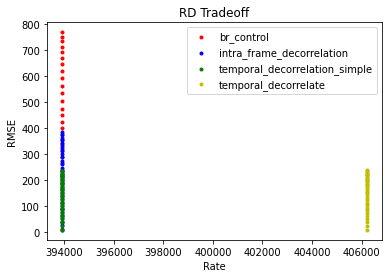

In [28]:
plt.title("RD Tradeoff")
plt.xlabel("Rate")
plt.ylabel("RMSE")
plt.scatter(*zip(*q_RD_points), c='r', marker=".", label='br_control')
plt.scatter(*zip(*MST_RD_points), c='b', marker=".", label='intra_frame_decorrelation')
plt.scatter(*zip(*DWT_RD_points), c='g', marker=".", label='temporal_decorrelation_simple')
plt.scatter(*zip(*DWT_RD_points_extended), c='y', marker=".", label='temporal_decorrelate')
plt.legend(loc='upper right')
plt.show()

In [ ]:
!python ./br_control.py --show_stats

In [ ]:
!python ./intra_frame_decorrelation.py --show_stats

In [ ]:
!python ./temporal_decorrelation_simple.py --show_stats

In [ ]:
!python ./temporal_decorrelate.py --show_stats